## Unsupervised Patient Phenotyping for Stroke Risk Analysis

Unsupervised Patient Phenotyping for Stroke Risk Analysis

Author: Brian Lee

Date: December 2025

Course: CSCA 5632

### INTRODUCTION

### Background

Stroke is one of the leading cause of death and long-term disability worldwide. It affects millions of people annually. While there is substantial research focused on predicting stroke occurrence using supervised machine learning, there has been less published analysis on understanding the natural heterogeneity in patient populations before outcomes occur. Clinical practice often treats risk factors like age, hypertension, diabetes, lifestyle behaviors as independent predictors. But patients rarely present with isolated risk factors, more often they arrive with complex, interrelated profiles.

### Problem Statement

Using unsupervised learning reveal patient grouping without imposing stroke outcomes as a training signal. Can unsupervised learning can be used to discover meaningful patient phenotypes based on demographics, clinical, and lifestyle characteristics? And if meaningful patient phenotypes are defined do they align with different stroke risks?

### Project Objectives

Healthcare Stroke Prediction Dataset (5,110 patients)

1. Discover latent patient subtypes through unsupervised clustering (K-Means, Gaussian Mixture Models, Hierarchical Clustering)

2. Characterize each phenotype by demographic, clinical, and lifestyle features

3. Compare clustering algorithms using multiple internal validation metrics (Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index)

4. Apply dimensionality reduction (PCA, t-SNE) to understand feature space structure and visualize clusters

5. Perform post-hoc analysis examining stroke prevalence within discovered clusters (without using stroke labels during clustering)

6. Compare with supervised learning to demonstrate the unique value of unsupervised phenotyping for data efficiency and interpretability

### Methods

Phase 1: Exploratory Data Analysis (EDA) with statistical validation

Phase 2: Data preprocessing (missing value imputation, encoding, scaling)

Phase 3: Dimensionality reduction and feature interpretation

Phase 4: Multi-algorithm clustering with hyperparameter optimization

Phase 5: Cluster validation and clinical interpretation

Phase 6: Comparison with supervised baselines

### Dataset Introduction

Stroke is one of the leading causes of death worldwide. Early risk prediction can support clinical decision-making and preventative health strategies.

### Dataset Citation
Fedesoriano. (2020). *Stroke Prediction Dataset.* Kaggle. https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  

### Dataset Size
5,110 Patients
12 Features

### Key Features
| Feature | Description |
|--------|-------------|
| gender | Male/Female |
| age | Age of the patient |
| hypertension | Has hypertension (0/1) |
| heart_disease | Has heart disease (0/1) |
| ever_married | Yes/No |
| work_type | Employment category |
| Residence_type | Urban/Rural |
| avg_glucose_level | Average glucose level |
| bmi | Body Mass Index |
| smoking_status | Smoking behavior |


## Phase 0: PROJECT CONFIGURATION

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from scipy.stats import chi2_contingency, f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## PHASE I: EXPLORATORY DATA ANALYSIS (EDA)

In [183]:
print("DATA LOADING & INSPECTION")
print("\n")

# Load data
df = pd.read_csv('./data/healthcare_dataset_stroke.csv')

# Basic info
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\n")
print(f"Columns: {list(df.columns)}")
print("\n")

# Check missing values
print("Missing Values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("\n")

# Stroke distribution
print(f"Stroke Prevalence: {100*df['stroke'].mean():.2f}%")
print(df['stroke'].value_counts())
print("\n")

# Quick look at data
print("First 3 rows:")
print(df.head(3))
print("\n")

print("Data types:")
print(df.dtypes)
print("\n")

print("Numerical summary:")
print(df[['age', 'avg_glucose_level', 'bmi']].describe())
print("\n")

DATA LOADING & INSPECTION


Shape: 5110 rows × 12 columns


Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']


Missing Values:
bmi    201
dtype: int64


Stroke Prevalence: 4.87%
stroke
0    4861
1     249
Name: count, dtype: int64


First 3 rows:
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1  


D

Target dataset includes 5,110 patients with 12 features, with stroke as a highly imbalanced target (≈4.9%). BMI has a small amount of missing data, and several numeric features show wide ranges that may contain outliers. No duplicate IDs were detected, and variable types are appropriate for clinical prediction analysis.

**Noted Observations**

Age Range: 0.08–82 years

Avg Glucose Range: 55–272 mg/dL

BMI Range: 10.3–97.6

EXPLORATORY DATA ANALYSIS


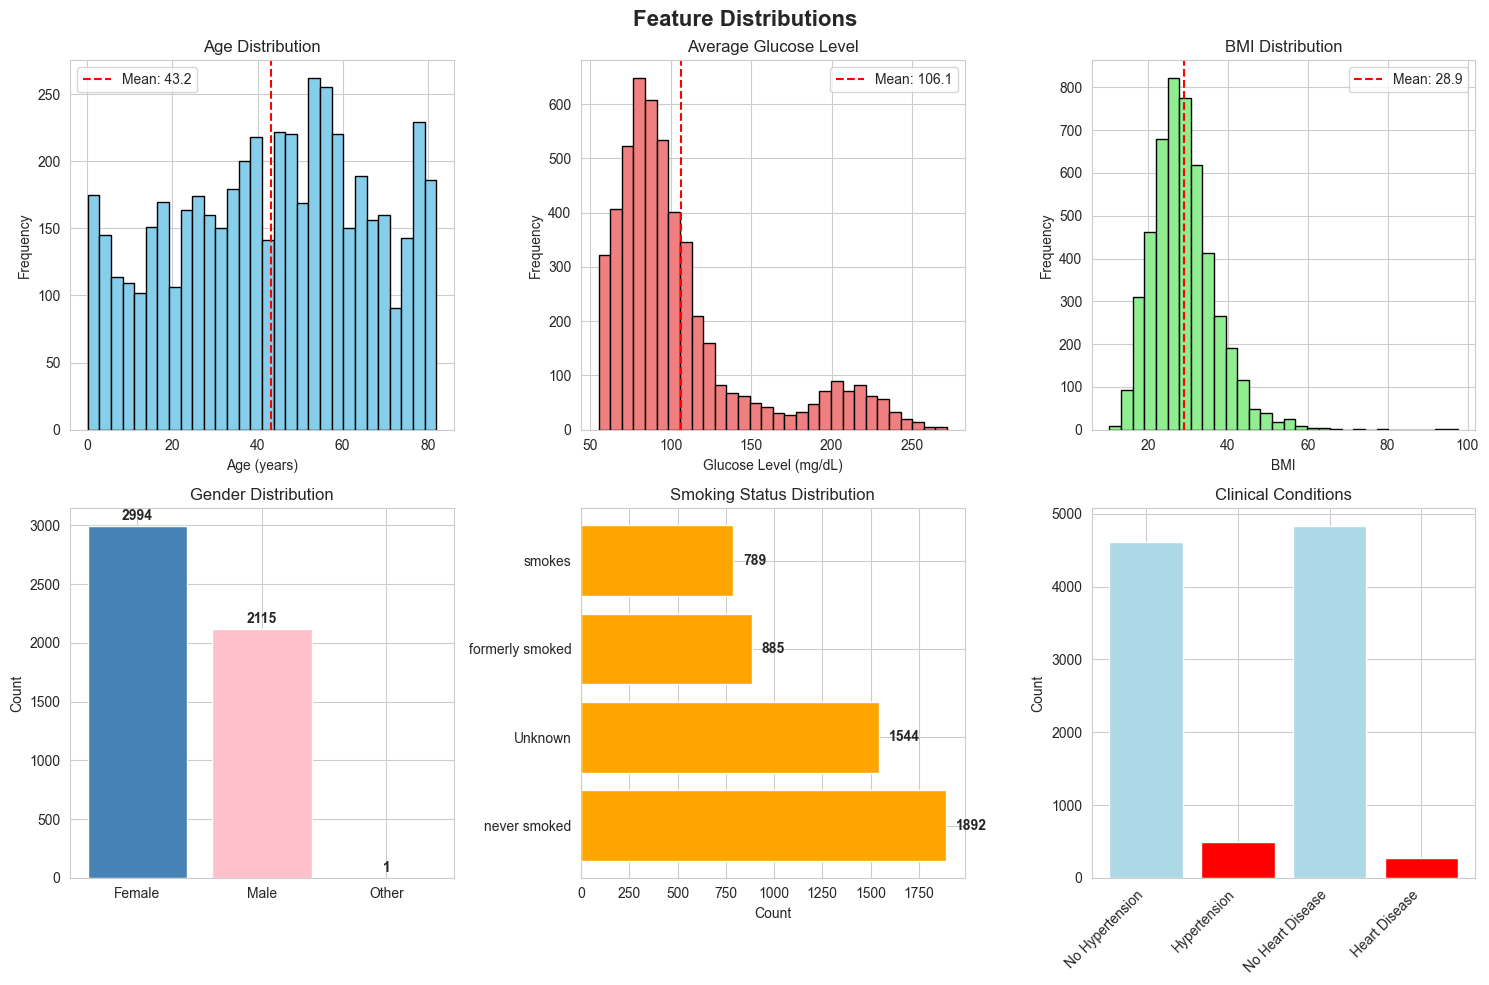

Feature Distributions:


gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64


work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64




In [184]:
print("EXPLORATORY DATA ANALYSIS")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Feature Distributions', fontsize=16, fontweight='bold')

axes[0, 0].hist(df['age'], bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age (years)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['age'].mean(), color='red', linestyle='--', label=f'Mean: {df["age"].mean():.1f}')
axes[0, 0].legend()

axes[0, 1].hist(df['avg_glucose_level'], bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Average Glucose Level')
axes[0, 1].set_xlabel('Glucose Level (mg/dL)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['avg_glucose_level'].mean(), color='red', linestyle='--', label=f'Mean: {df["avg_glucose_level"].mean():.1f}')
axes[0, 1].legend()

axes[0, 2].hist(df['bmi'].dropna(), bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('BMI Distribution')
axes[0, 2].set_xlabel('BMI')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(df['bmi'].mean(), color='red', linestyle='--', label=f'Mean: {df["bmi"].mean():.1f}')
axes[0, 2].legend()

gender_counts = df['gender'].value_counts()
axes[1, 0].bar(gender_counts.index, gender_counts.values, color=['steelblue', 'pink'])
axes[1, 0].set_title('Gender Distribution')
axes[1, 0].set_ylabel('Count')
for i, v in enumerate(gender_counts.values):
    axes[1, 0].text(i, v + 50, str(v), ha='center', fontweight='bold')

smoking_counts = df['smoking_status'].value_counts()
axes[1, 1].barh(smoking_counts.index, smoking_counts.values, color='orange')
axes[1, 1].set_title('Smoking Status Distribution')
axes[1, 1].set_xlabel('Count')
for i, v in enumerate(smoking_counts.values):
    axes[1, 1].text(v + 50, i, str(v), va='center', fontweight='bold')

conditions = ['No Hypertension', 'Hypertension', 'No Heart Disease', 'Heart Disease']
values = [
    (df['hypertension'] == 0).sum(),
    (df['hypertension'] == 1).sum(),
    (df['heart_disease'] == 0).sum(),
    (df['heart_disease'] == 1).sum()
]
colors_cond = ['lightblue', 'red', 'lightblue', 'red']
axes[1, 2].bar(range(4), values, color=colors_cond)
axes[1, 2].set_title('Clinical Conditions')
axes[1, 2].set_xticks(range(4))
axes[1, 2].set_xticklabels(conditions, rotation=45, ha='right')
axes[1, 2].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("Feature Distributions:")
print("\n")
for col in ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']:
    print(f"{col}:")
    print(df[col].value_counts())
    print("\n")

Numerical features show realistic ranges with skewed glucose values and slightly high average BMI. Most categorical variables are balanced, though smoking has a large unknown category that requires preprocessing. Hypertension and heart disease are present in only a small minority of patients.

**Noted Observations**

Age: broad range; mean ~43

Glucose: right-skewed

BMI: slightly overweight average

Smoking: ~30% unknown

Urban/Rural: nearly equal

Hypertension ~10%, Heart disease ~5%

### CORRELATION & BIVARIATE ANALYSIS

CORRELATION & BIVARIATE ANALYSIS




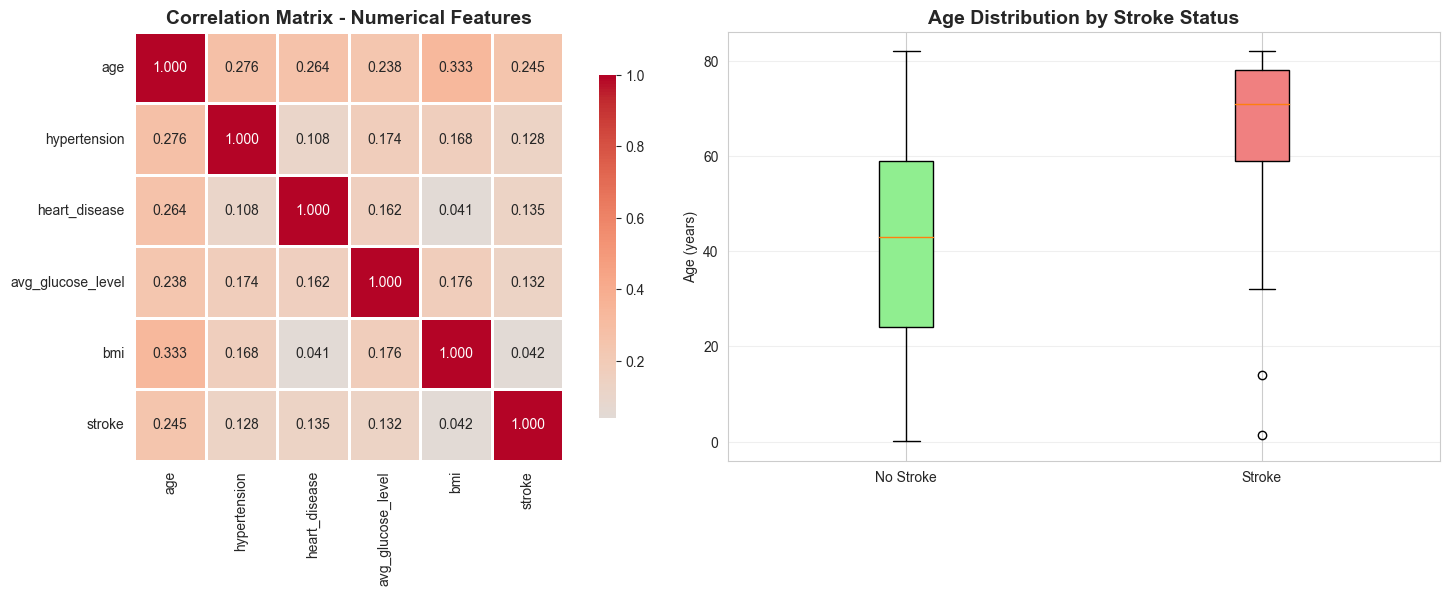

Age by Stroke Status:
         count       mean        std   min   25%   50%   75%   max
stroke                                                            
0       4861.0  41.971545  22.291940  0.08  24.0  43.0  59.0  82.0
1        249.0  67.728193  12.727419  1.32  59.0  71.0  78.0  82.0


Glucose by Stroke Status:
         count        mean        std    min    25%     50%     75%     max
stroke                                                                     
0       4861.0  104.795513  43.846069  55.12  77.12   91.47  112.83  267.76
1        249.0  132.544739  61.921056  56.11  79.79  105.22  196.71  271.74


BMI by Stroke Status:
         count       mean       std   min   25%   50%   75%   max
stroke                                                           
0       4700.0  28.823064  7.908287  10.3  23.4  28.0  33.1  97.6
1        209.0  30.471292  6.329452  16.9  26.4  29.7  33.7  56.6


Stroke Prevalence by Categorical Features:


gender:
        Stroke_Count  Total  Stroke

In [185]:
print("CORRELATION & BIVARIATE ANALYSIS")
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
corr_matrix = df[numerical_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')

stroke_labels = ['No Stroke', 'Stroke']
stroke_data = [df[df['stroke']==0]['age'], df[df['stroke']==1]['age']]
bp = axes[1].boxplot(stroke_data, labels=stroke_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
axes[1].set_title('Age Distribution by Stroke Status', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Age (years)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Age by Stroke Status:")
print(df.groupby('stroke')['age'].describe())
print("\n")

print("Glucose by Stroke Status:")
print(df.groupby('stroke')['avg_glucose_level'].describe())
print("\n")

print("BMI by Stroke Status:")
print(df.groupby('stroke')['bmi'].describe())
print("\n")

print("Stroke Prevalence by Categorical Features:")
print("\n")

categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                        'work_type', 'Residence_type', 'smoking_status']

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df['stroke'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"{feature}:")
    stroke_by_category = df.groupby(feature)['stroke'].agg(['sum', 'count', 'mean'])
    stroke_by_category.columns = ['Stroke_Count', 'Total', 'Stroke_Rate']
    stroke_by_category['Stroke_Rate'] = stroke_by_category['Stroke_Rate'] * 100
    print(stroke_by_category.sort_values('Stroke_Rate', ascending=False))
    print(f"  Chi-square p-value: {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
    print("\n")

| Variable        | Corr with Stroke | Mean (No Stroke) | Mean (Stroke) | Stroke Rate Difference         | p-value         |
|----------------|------------------|------------------|---------------|--------------------------------|-----------------|
| Age            | 0.245            | 42               | 68            | Higher in older patients       | < 0.001 ***     |
| Hypertension   | 0.128            | —                | —             | 13.3% vs 4.0%                  | < 0.001 ***     |
| Heart disease  | 0.135            | —                | —             | 17.0% vs 4.2%                  | < 0.001 ***     |
| Glucose        | 0.132            | 104.8 mg/dL      | 132.5 mg/dL   | Higher in stroke patients      | < 0.001 ***     |
| BMI            | 0.042            | 28.8             | 30.5          | Small difference               | —               |
| Gender         | —                | —                | —             | 5.1% vs 4.7%                   | 0.789  ns       |
| Residence type | —                | —                | —             | 5.2% vs 4.5%                   | 0.298  ns       |
| Ever married   | —                | —                | —             | 6.6% vs 1.7%                   | < 0.001 ***     |
| Work type      | —                | —                | —             | Self-employed highest (7.9%)   | < 0.001 ***     |
| Smoking status | —                | —                | —             | Former highest (7.9%)          | < 0.001 ***     |

Stroke risk increases most strongly with age, with additional elevation among people with hypertension, heart disease, and higher glucose levels. BMI shows only a weak association. Former smokers and self-employed individuals appear to have higher stroke rates, although this is likely influenced by confounding factors. The low rate among those with “unknown” smoking status suggests a missing-data issue rather than a true protective effect.

## PHASE II: DATA PREPROCESSING

In [186]:
print("DATA PREPROCESSING")
print("\n")

df_processed = df.copy()

df_processed = df_processed.drop('id', axis=1)
df_processed = df_processed[df_processed['gender'] != 'Other']

df_processed['bmi'].fillna(df_processed['bmi'].median(), inplace=True)

print(f"Shape after cleaning: {df_processed.shape}")
print(f"Missing values: {df_processed.isnull().sum().sum()}")
print("\n")

X = df_processed.drop('stroke', axis=1)
y = df_processed['stroke']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print("\n")

categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"After encoding: {X_encoded.shape[1]} features")
print(f"Feature names: {list(X_encoded.columns)}")
print("\n")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

print(f"Final preprocessed data: {X_scaled.shape}")
print("\n")

DATA PREPROCESSING


Shape after cleaning: (5109, 11)
Missing values: 0


Features (X): (5109, 10)
Target (y): (5109,)


After encoding: 15 features
Feature names: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']


Final preprocessed data: (5109, 15)




Target dataset was preprocessed to 5,109 patients and 15 features by removing the ID column and the single “Other” gender case, imputing 201 BMI values with the median, one-hot encoding five categorical variables, scaling all features with StandardScaler, and saving the stroke label separately for analysis.

## PHASE III: DIMENSIONALITY REDUCTION (PCA)

PRINCIPAL COMPONENT ANALYSIS (PCA)


Total components: 15


Components needed for 90% variance: 11
Components needed for 95% variance: 12




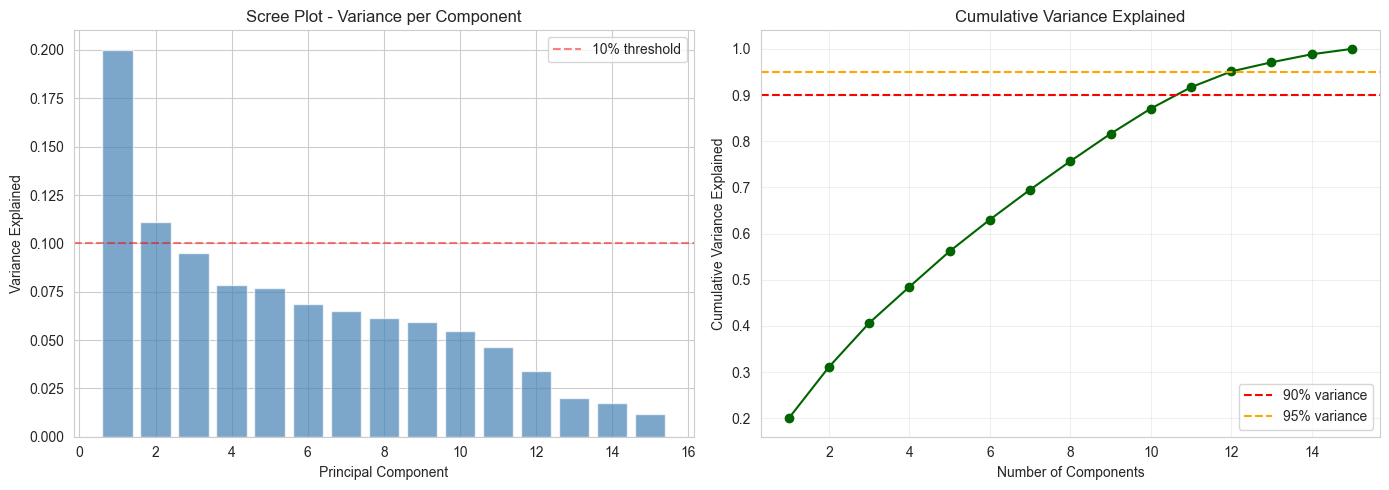

2D PCA variance explained: 0.311 (31.1%)
  PC1: 20.0%
  PC2: 11.1%




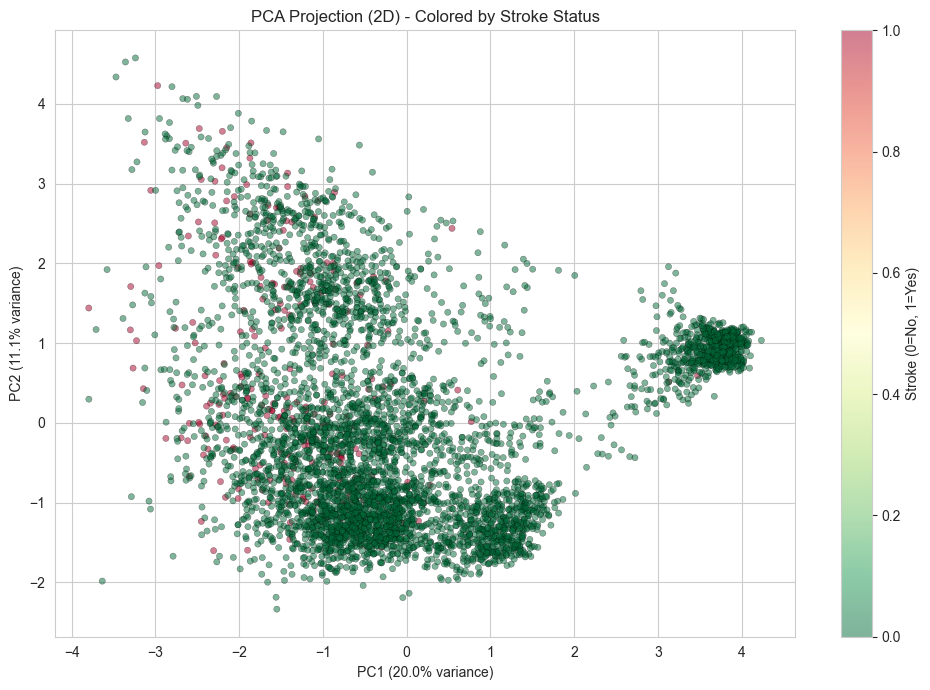

Top 5 features for PC1:
age                   0.498019
work_type_children    0.473299
ever_married_Yes      0.450998
bmi                   0.338322
hypertension          0.207014
Name: PC1, dtype: float64


Top 5 features for PC2:
work_type_Private                 0.625919
work_type_Self-employed           0.558574
smoking_status_never smoked       0.238302
smoking_status_formerly smoked    0.237350
work_type_children                0.214208
Name: PC2, dtype: float64




In [187]:
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("\n")

pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

variance_explained = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"Total components: {len(variance_explained)}")
print("\n")

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(variance_explained)+1), variance_explained, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot - Variance per Component')
axes[0].axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='10% threshold')
axes[0].legend()

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='darkgreen')
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"2D PCA variance explained: {pca_2d.explained_variance_ratio_.sum():.3f} ({100*pca_2d.explained_variance_ratio_.sum():.1f}%)")
print(f"  PC1: {100*pca_2d.explained_variance_ratio_[0]:.1f}%")
print(f"  PC2: {100*pca_2d.explained_variance_ratio_[1]:.1f}%")
print("\n")

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                     c=y, cmap='RdYlGn_r', alpha=0.5, s=20, edgecolors='k', linewidth=0.3)
ax.set_xlabel(f'PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}% variance)')
ax.set_ylabel(f'PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}% variance)')
ax.set_title('PCA Projection (2D) - Colored by Stroke Status')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Stroke (0=No, 1=Yes)')
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=X_encoded.columns
)

print("Top 5 features for PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(5))
print("\n")

print("Top 5 features for PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False).head(5))
print("\n")

PCA required 11 components to explain 90% of the variance, indicating relatively high dimensionality. The first two components explained about 31% and mainly reflected age/life stage and employment type. There were no visually distinct clusters, and stroke cases were dispersed broadly, suggesting overlapping patient profiles and supporting an unsupervised approach.

**Noted Observations**

PC1 (20%): age, BMI, marital status → “young-to-old” axis

PC2 (11%): work type differences

No clear clusters; stroke cases scattered

### DETERMINE OPTIMAL NUMBER OF CLUSTERS

OPTIMAL CLUSTER NUMBER DETERMINATION
Computing metrics for k = 2 to 10...




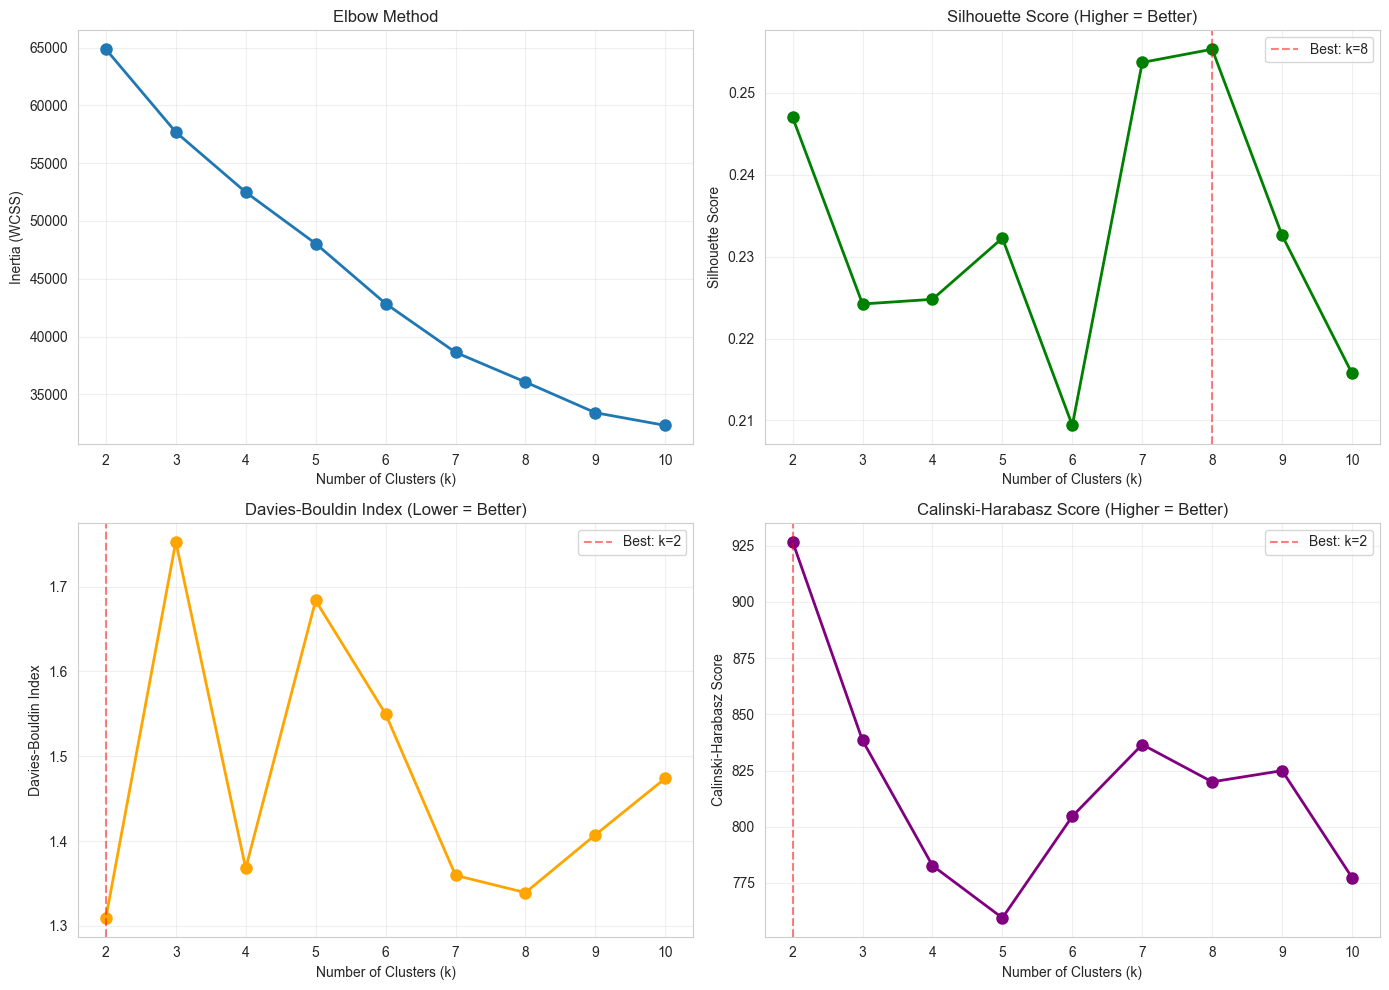

Clustering Metrics Summary:
    k    Inertia  Silhouette  Davies_Bouldin  Calinski_Harabasz
0   2  64864.002       0.247           1.309            926.777
1   3  57690.327       0.224           1.753            838.368
2   4  52490.559       0.225           1.368            782.727
3   5  48041.382       0.232           1.684            759.459
4   6  42850.871       0.209           1.550            804.653
5   7  38629.820       0.254           1.360            836.584
6   8  36059.517       0.255           1.339            819.976
7   9  33406.028       0.233           1.407            824.955
8  10  32305.737       0.216           1.474            777.416


Optimal k by each metric:
  Silhouette Score: k = 8 (score: 0.255)
  Davies-Bouldin: k = 2 (score: 1.309)
  Calinski-Harabasz: k = 2 (score: 926.8)


In [188]:
print("OPTIMAL CLUSTER NUMBER DETERMINATION")

k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Computing metrics for k = 2 to 10...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

print("\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (WCSS)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(k_range, silhouette_scores, marker='o', color='green', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher = Better)')
axes[0, 1].grid(alpha=0.3)
best_sil_k = list(k_range)[np.argmax(silhouette_scores)]
axes[0, 1].axvline(best_sil_k, color='red', linestyle='--', alpha=0.5, label=f'Best: k={best_sil_k}')
axes[0, 1].legend()

axes[1, 0].plot(k_range, davies_bouldin_scores, marker='o', color='orange', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower = Better)')
axes[1, 0].grid(alpha=0.3)
best_db_k = list(k_range)[np.argmin(davies_bouldin_scores)]
axes[1, 0].axvline(best_db_k, color='red', linestyle='--', alpha=0.5, label=f'Best: k={best_db_k}')
axes[1, 0].legend()

axes[1, 1].plot(k_range, calinski_harabasz_scores, marker='o', color='purple', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher = Better)')
axes[1, 1].grid(alpha=0.3)
best_ch_k = list(k_range)[np.argmax(calinski_harabasz_scores)]
axes[1, 1].axvline(best_ch_k, color='red', linestyle='--', alpha=0.5, label=f'Best: k={best_ch_k}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Davies_Bouldin': davies_bouldin_scores,
    'Calinski_Harabasz': calinski_harabasz_scores
})

print("Clustering Metrics Summary:")
print(results_df.round(3))
print("\n")

print("Optimal k by each metric:")
print(f"  Silhouette Score: k = {best_sil_k} (score: {max(silhouette_scores):.3f})")
print(f"  Davies-Bouldin: k = {best_db_k} (score: {min(davies_bouldin_scores):.3f})")
print(f"  Calinski-Harabasz: k = {best_ch_k} (score: {max(calinski_harabasz_scores):.1f})")

Although k=2 is optimal by most scores, k=4 is recommended as a clinically interpretable compromise capturing more nuanced patient phenotypes without excessive complexity.

**Notes Observations**

Silhouette: favors k≈8 (best = 0.255)

Davies-Bouldin: best at k=2 (lowest = 1.309)

Calinski-Harabasz: best at k=2 (highest = 926.8)

Elbow method: suggests diminishing returns after about k=4–5

**Summary**

k=2 separates broad groups (likely younger vs older/clinical risk)

k≥7 picks up finer sub-patterns but may reduce interpretability

k≈4 provides a balanced middle ground with meaningful segmentation and reduced over-clustering

### K-MEANS CLUSTERING WITH k=4

K-MEANS CLUSTERING (k=4)
K-Means with k=4 fitted
Iterations: 13
Inertia: 52490.56


Cluster Sizes:
  Cluster 0: 688 patients (13.5%)
  Cluster 1: 822 patients (16.1%)
  Cluster 2: 3577 patients (70.0%)
  Cluster 3: 22 patients (0.4%)


Clustering Quality Metrics:
  Silhouette Score: 0.225
  Davies-Bouldin Index: 1.368
  Calinski-Harabasz Score: 782.7




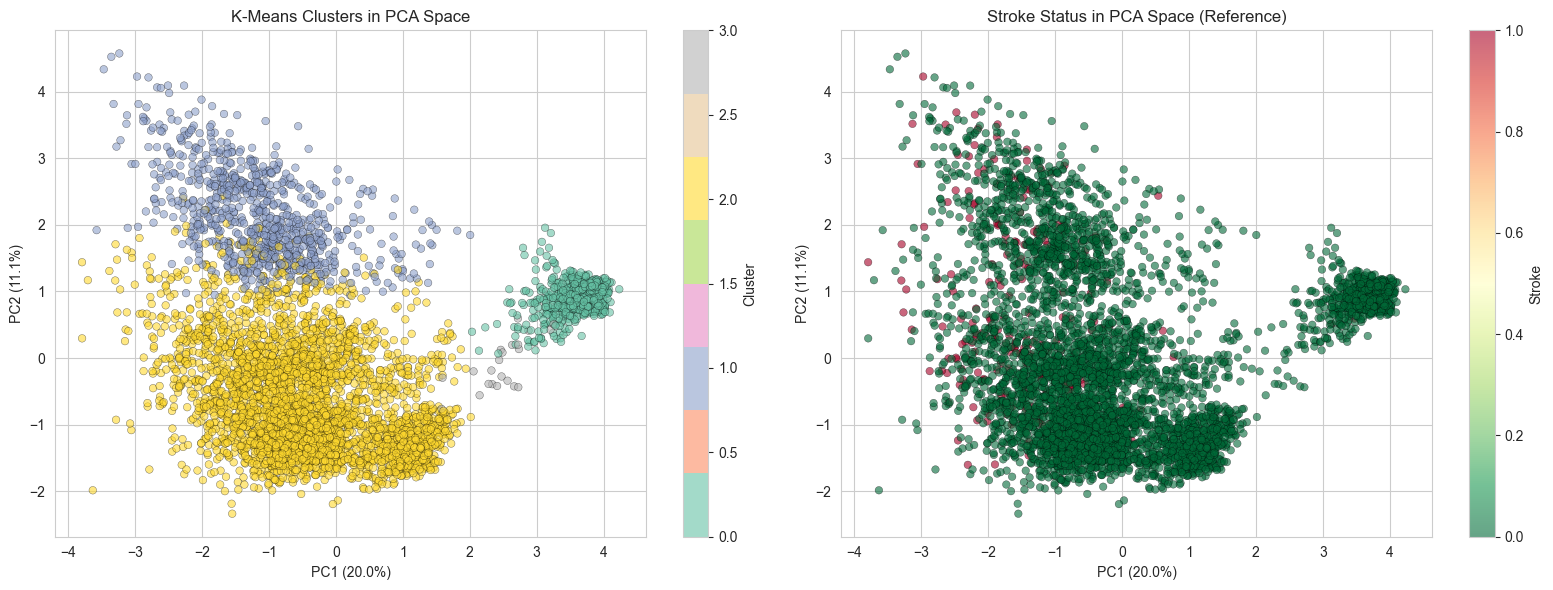

In [189]:
print("K-MEANS CLUSTERING (k=4)")

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=50)
cluster_labels = kmeans.fit_predict(X_scaled)

df_processed['cluster'] = cluster_labels

print(f"K-Means with k={optimal_k} fitted")
print(f"Iterations: {kmeans.n_iter_}")
print(f"Inertia: {kmeans.inertia_:.2f}")
print("\n")

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("Cluster Sizes:")
for i in range(optimal_k):
    print(f"  Cluster {i}: {cluster_counts[i]} patients ({100*cluster_counts[i]/len(cluster_labels):.1f}%)")
print("\n")

sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)
ch_score = calinski_harabasz_score(X_scaled, cluster_labels)

print("Clustering Quality Metrics:")
print(f"  Silhouette Score: {sil_score:.3f}")
print(f"  Davies-Bouldin Index: {db_score:.3f}")
print(f"  Calinski-Harabasz Score: {ch_score:.1f}")
print("\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=cluster_labels, cmap='Set2', alpha=0.6, s=30, edgecolors='k', linewidth=0.3)
axes[0].set_xlabel(f'PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)')
axes[0].set_ylabel(f'PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)')
axes[0].set_title('K-Means Clusters in PCA Space')
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Cluster')

scatter2 = axes[1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=y, cmap='RdYlGn_r', alpha=0.6, s=30, edgecolors='k', linewidth=0.3)
axes[1].set_xlabel(f'PC1 ({100*pca_2d.explained_variance_ratio_[0]:.1f}%)')
axes[1].set_ylabel(f'PC2 ({100*pca_2d.explained_variance_ratio_[1]:.1f}%)')
axes[1].set_title('Stroke Status in PCA Space (Reference)')
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Stroke')

plt.tight_layout()
plt.show()

K-Means with k=4 produced one dominant cluster (70%) and one extremely small cluster (~0.4%), suggesting mostly overlapping patient profiles with a small outlier group. Separation is visible in PCA space, but stroke cases appear across all clusters, indicating that clustering reflects demographic patterns rather than stroke-specific segmentation. Overall clustering quality is moderate (silhouette = 0.225), consistent with non-distinct natural groupings in the data.

**Noted Observations**

Cluster distribution is highly imbalanced (one large cluster + one tiny cluster)

PCA shows separation mainly along age / clinical profile dimensions

Small cluster likely represents outliers or rare patient patterns

Stroke cases occur in every cluster (not cluster-specific)